In [ ]:
save_path = '/content/drive/MyDrive/bio-data/AN1-saint-base-build-MHA-2-CLB-FinalRun-2/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Nov 23 22:23:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import shutil
shutil.copyfile('/content/drive/MyDrive/bio-data/ok.zip', './ok.zip')
!unzip ok.zip

shutil.copyfile('/content/drive/MyDrive/bio-data/training-needs.zip', './train.zip')
!unzip train.zip

Archive:  ok.zip
replace Test/5G6UA.fasta? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Test/5G6UA.fasta        
  inflating: Test/5G6UA.hhm          
  inflating: Test/5G6UA.pssm         
  inflating: Test/5G6UA.spotcon      
  inflating: Test/5G6UA.ss           
  inflating: Test/5H7KA.fasta        
  inflating: Test/5H7KA.hhm          
  inflating: Test/5H7KA.pssm         
  inflating: Test/5H7KA.spotcon      
  inflating: Test/5H7KA.ss           
  inflating: 0norm_data.p            
  inflating: 1norm_data.p            
  inflating: 5norm_data.p            
  inflating: aa_phy7                 
  inflating: config.py               
  inflating: GenerateBaseFeature.py  
  inflating: GenerateForWindow10.py  
  inflating: GenerateForWindow20.py  
  inflating: GenerateForWindow50.py  
  inflating: GenerateLengthList.py   
  inflating: list_test               
  inflating: SAINT_ensemble.py       
  inflating: SAINT_single_base_model.py  
Archive:  train.zip
replace training-ne

In [ ]:
########### Select Tensorflow and Keras Version
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
########## imports
# tensorflow and keras functions
import tensorflow as tensorflow
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Input,SpatialDropout1D, Embedding, LSTM, Dense, merge, Convolution2D, Lambda, GRU, TimeDistributed, Reshape, Permute, Convolution1D, Masking, Bidirectional
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras import optimizers, callbacks
from keras.layers import Layer
from keras.initializers import Ones, Zeros
from keras.layers import Layer
from keras.engine.topology import Layer
from keras.layers import add
from keras.layers import RepeatVector, Multiply, Flatten, Dot, Softmax, Lambda
from keras import backend
from keras.layers import RepeatVector
from keras.layers import Embedding, Add, concatenate
from keras.layers import BatchNormalization, Dropout

# python built-in
from time import time
import numpy as np
import gc
import random
import math

# custom 
import config
from config import *
from GenerateBaseFeature import generateBaseDataset
from GenerateLengthList import generateLengthlistAndAttentionMask

print(tensorflow.__version__)
print(keras.__version__)

1.15.2
2.3.1


Using TensorFlow backend.


In [ ]:
def truncated_accuracy(y_true, y_predict):
    mask = K.sum(y_true, axis=2)
    y_pred_labels = K.cast(K.argmax(y_predict, axis=2), 'float32')
    y_true_labels = K.cast(K.argmax(y_true, axis=2), 'float32')
    is_same = K.cast(K.equal(
        y_true_labels, y_pred_labels), 'float32')
    num_same = K.sum(is_same * mask, axis=1)
    lengths = K.sum(mask, axis=1)
    # return K.cast(K.sum(num_same, axis=0) / K.sum(lengths, axis=0), 'float32')
    return Lambda(lambda x: x[0]/x[1])([K.sum(num_same, axis=0), K.sum(lengths, axis=0)])

class LayerNormalization(Layer):
    def __init__(self, eps: float = 1e-5, **kwargs) -> None:
        self.eps = eps
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:], initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:], initializer=Zeros(), trainable=True)
        super().build(input_shape)

    def call(self, x, **kwargs):
        u = K.mean(x, axis=-1, keepdims=True)
        s = K.mean(K.square(x - u), axis=-1, keepdims=True)
        z = (x - u) / K.sqrt(s + self.eps)
        return self.gamma * z + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'eps': self.eps,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

class MyLayer(Layer):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self._x = K.variable(0.2)
        self._x._trainable = True
        self.trainable_weights = [self._x]

        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        A, B = x
        result = add([self._x*A ,(1-self._x)*B])
        return result

    def compute_output_shape(self, input_shape):
        return input_shape[0]

def attention(activations):
#https://arxiv.org/pdf/1703.03130.pdf
    d_a = 10
    r = 1
    units = activations.shape[2]
    #print(activations.shape)
    attention = TimeDistributed(Dense(d_a, activation='tanh', use_bias=False))(activations)
    attention = Dropout(.5)(attention)
    #print(attention.shape)
    attention = TimeDistributed(Dense(r, activation='softmax', use_bias=False))(activations) 
    #print(attention.shape)
    attention = Flatten()(attention)
    #attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)
    #print(attention.shape)
    attention = Permute([2, 1])(attention)
    #print(attention.shape)

    # apply the attention
    sent_representation = Multiply()([activations, attention])
    #sent_representation = Lambda(lambda xin: K.dot(xin[0], xin[1]))([attention, activations])
    #print(sent_representation.shape)
    #sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)
    #print(sent_representation.shape)
    return sent_representation

def shape_list(x):
    #   https://github.com/Separius/BERT-keras/blob/master/transformer/funcs.py
    if backend.backend() != 'theano':
        tmp = backend.int_shape(x)
    else:
        tmp = x.shape
    tmp = list(tmp)
    tmp[0] = -1
    return tmp

def attention_scaled_dot(activations, attention_mask, head = 1): #, length):
#https://arxiv.org/pdf/1706.03762.pdf
    units = int(activations.shape[2])
    words = int(activations.shape[1])
    print('Activations.shape: ',activations.shape)
    _drop_rate_ = .1
    hidden_dimension = int(units/head)
    Q = TimeDistributed(Dense(hidden_dimension, activation=None, use_bias=False))(activations)
    Q = Dropout(_drop_rate_)(Q)
    K = TimeDistributed(Dense(hidden_dimension, activation=None, use_bias=False))(activations)
    K = Dropout(_drop_rate_)(K)
    V = TimeDistributed(Dense(hidden_dimension, activation=None, use_bias=False))(activations)
    V = Dropout(_drop_rate_)(V)
    print('Q.shape: ',Q.shape)
    QK_T = Dot(axes=-1, normalize=False)([Q,K]) # list of two tensors
    print('QK_T.shape: ', QK_T.shape)
    """normalize: Whether to L2-normalize samples along the dot product axis before taking the dot product. If set to True, then the output of the dot product is the cosine proximity between the two samples."""
    QK_T = Lambda( lambda inp: inp[0]/ backend.sqrt(backend.cast(shape_list(inp[1])[-1], backend.floatx())))([QK_T, V])
    print('QK_T.shape: ', QK_T.shape)
    
#     cropping = np.zeros(QK_T.shape[1])
#     cropping[length:] = (-10**6) * np.ones(int(QK_T.shape[1])-length)
#     QK_T = QK_T + cropping
    print('att mask origin shape: ',attention_mask.shape)
    attention_mask__ = RepeatVector(int(QK_T.shape[1]))(attention_mask)
    print('att mask shape: ',attention_mask__.shape)
    QK_T = Add()([QK_T, attention_mask__])
    print('Add QK and mask: ',attention_mask__.shape)
    QK_T = Softmax(axis=-1)(QK_T)
    QK_T = Dropout(_drop_rate_)(QK_T)
    #print(V.shape)
    V = Permute([2, 1])(V)
    print('V premute shape: ', V.shape)
    V_prime = Dot(axes=-1, normalize=False)([QK_T,V]) # list of two tensors
    print('V_prime shape: ', V_prime.shape)
    return V_prime

def _get_pos_encoding_matrix(protein_len: int, d_emb: int) -> np.array:
    pos_enc = np.array(
        [[pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] if pos != 0 else np.zeros(d_emb) for pos in
         range(protein_len)], dtype=np.float32)
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def embeddings(inputs):
    gene_ids, pos_ids = inputs
    gene_vocab_len = 22
    protein_len = 700
    output_dim = 50
    gene_embedding = Embedding(gene_vocab_len, output_dim, input_length=protein_len,
                                              name='GeneEmbedding')(gene_ids)

    pos_embedding = Embedding(protein_len, output_dim, trainable=False, input_length=protein_len,
                                              name='PositionEmbedding',
                                              weights=[_get_pos_encoding_matrix(protein_len, output_dim)])(pos_ids)

    summation = Add(name='AddEmbeddings')([Dropout(.1, name='EmbeddingDropOut1')(gene_embedding), 
                                           Dropout(.1, name='EmbeddingDropOut2')(pos_embedding)])
    
#     summation = concatenate([Dropout(.1, name='EmbeddingDropOut1')(gene_embedding), 
#                              Dropout(.1, name='EmbeddingDropOut2')(pos_embedding)])
    
    summation = LayerNormalization(1e-5)(summation)
    return summation

def gene_embeddings(gene_ids, output_dim=50):
    gene_vocab_len = 22
    protein_len = 700
    
    gene_emb = Dropout(.1)(Embedding(gene_vocab_len, output_dim, input_length=protein_len,
                               name='GeneEmbedding')(gene_ids))

    gene_emb = LayerNormalization(1e-5)(gene_emb)
    return gene_emb


def position_embedding(pos_ids, output_dim=50):
    #gene_vocab_len = 22
    protein_len = 700
    output_dim = int(output_dim)

    pos_emb = Dropout(.1)(Embedding(protein_len, output_dim, trainable=False, input_length=protein_len,
                        #name='PositionEmbedding',
                        weights=[_get_pos_encoding_matrix(protein_len, output_dim)])(pos_ids))
    
    pos_emb = LayerNormalization(1e-5)(pos_emb)
    return pos_emb


def attention_module(x, attention_mask, pos_ids=None, drop_rate=.1, ccnt=None, head = 1):
    
    original_dim = int(x.shape[-1])
    
    if ccnt is not None:
        print('aatt--------x1-> '+str(x.shape))
        print('original dim--------x1-> '+str(original_dim))
    if pos_ids is not None:
        pos_embedding = position_embedding(pos_ids=pos_ids, output_dim=original_dim)
        #x = concatenate([x, pos_embedding])
        x = Add()([x, pos_embedding])

    if ccnt is not None:
        print('aatt--------x2-> '+str(x.shape))

    
    att_layer_head1 = attention_scaled_dot(x, attention_mask, head) ## our code
    att_layer_head2 = attention_scaled_dot(x, attention_mask, head) ## our code

    att_layer = keras.layers.Concatenate(axis = -1)([att_layer_head1,att_layer_head2]) ## our code
    if ccnt is not None:
        print('aatt--------att_layer1-> '+str(att_layer.shape))
    att_layer = Dropout(drop_rate)(att_layer)

    att_layer = TimeDistributed(Dense(original_dim, activation=None, use_bias=False))(att_layer) ## our code

    if ccnt is not None:
        print('aatt--------att_layer2-> '+str(att_layer.shape))
    x = MyLayer()([att_layer, x])

    if ccnt is not None:
        print('aatt--------my-> '+str(x.shape))
    x = Dropout(drop_rate)(x)
    x = BatchNormalization()(x)
#     if False:
#         # reduce dim
#         x = Convolution1D(original_dim, 1, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
#         x = Dropout(drop_rate*2)(x)
#         x = BatchNormalization()(x)
    # ccnt +=1
    return x

def inceptionBlock(x):
    _drop_rate_ = .1
    x = BatchNormalization()(x)
    print('inceptionblock before CONV '+ str(x.shape))
    conv1_1 = Convolution1D(100, 1, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    print('inceptionblock after CONV '+ str(conv1_1.shape))
    conv1_1 = Dropout(_drop_rate_)(conv1_1) #https://www.quora.com/Can-l-combine-dropout-and-l2-regularization
    conv1_1 = BatchNormalization()(conv1_1)
    
    conv2_1 = Convolution1D(100, 1, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    conv2_1 = Dropout(_drop_rate_)(conv2_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Convolution1D(100, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv2_1)
    conv2_2 = Dropout(_drop_rate_)(conv2_2)
    conv2_2 = BatchNormalization()(conv2_2)
    
    conv3_1 = Convolution1D(100, 1, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    conv3_1 = Dropout(_drop_rate_)(conv3_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Convolution1D(100, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3_1)
    conv3_2 = Dropout(_drop_rate_)(conv3_2)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Convolution1D(100, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3_2)
    conv3_3 = Dropout(_drop_rate_)(conv3_3)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Convolution1D(100, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv3_3)
    conv3_4 = Dropout(_drop_rate_)(conv3_4)
    conv3_4 = BatchNormalization()(conv3_4)
    
    concat = concatenate([conv1_1, conv2_2, conv3_4])
    concat = BatchNormalization()(concat)
    
    return concat

def deep3iBLock_with_attention(x, attention_mask, pos_ids=None):
    print('x-> '+str(x.shape))
    block1_1 = inceptionBlock(x)
    print('block1_1-> '+str(block1_1.shape))
    block1_1 = attention_module(block1_1, attention_mask, pos_ids,ccnt=1, head = 2)
    print('block1_1-> '+str(block1_1.shape))

    block2_1 = inceptionBlock(x)
    print('block2_1-> '+str(block2_1.shape))
    block2_2 = inceptionBlock(block2_1)
    print('block2_1-> '+str(block2_1.shape))
    block2_2 = attention_module(block2_2, attention_mask, pos_ids, head = 2)
    print('block2_2-> '+str(block2_2.shape))


    block3_1 = inceptionBlock(x)
    block3_2 = inceptionBlock(block3_1)
    block3_3 = inceptionBlock(block3_2)
    block3_4 = inceptionBlock(block3_3)
    print('block3_4-> '+str(block3_4.shape))
    block3_4 = attention_module(block3_4, attention_mask, pos_ids, head = 2)
    print('block3_4-> '+str(block3_4.shape))

    concat = concatenate([block1_1, block2_2, block3_4])
    concat = BatchNormalization()(concat)
    
    return concat

def get_model(num_feature):
#   pssm_input = Input(shape=(700,21,), name='pssm_input')
#   seq_input = Input(shape=(700,22,), name='seq_input')
  _drop_rate_ = .4
  main_input = Input(shape=(700,num_feature,), name='main_input')
  attention_mask = Input(shape=(700,), name='attention_mask')
  pos_ids = Input(shape=(700,), name='position_input', dtype='int32')
  
  #pos_emb = position_embedding(pos_ids, output_dim=50)
#   main_input = concatenate([seq_input, pssm_input])
  
  block1 = deep3iBLock_with_attention(main_input, attention_mask, pos_ids)
#   att_layer_4 = attention_scaled_dot(block1)
#   block1 = MyLayer()([att_layer_4 ,block1])
#   block1 = BatchNormalization()(block1)
  
  block2 = deep3iBLock_with_attention(block1, attention_mask, pos_ids)
  block2 = attention_module(block2, attention_mask, pos_ids, head = 2)
  
  conv11 = Convolution1D(100, 11, activation='relu', padding='same', kernel_regularizer=l2(0.001))(block2)
#   conv11 = BatchNormalization()(conv11)
  conv11 = attention_module(conv11, attention_mask, pos_ids, head = 2)

  dense1 = TimeDistributed(Dense(units=256,activation='relu'))(conv11)
  dense1 = Dropout(_drop_rate_)(dense1)
  dense1 = attention_module(dense1, attention_mask, pos_ids, head = 2)
  
  print('before final: -------------------' + str(dense1.shape))
  main_output = TimeDistributed(Dense(units=8,activation='softmax', name='main_output'))(dense1)
  print('after final: -------------------' + str(main_output.shape))
#   main_output = TimeDistributed(Dense(units=8,activation='softmax', name='main_output'))(block1)
  
  model = Model([main_input, attention_mask, pos_ids],main_output)
  return model

class StepDecay():
  def __init__(self, initAlpha=0.0005, factor=0.9, dropEvery=60, min_lr=0.00001):
    self.initAlpha = initAlpha
    self.factor = factor
    self.dropEvery = dropEvery
    self.min_lr = min_lr

  def __call__(self, epoch):
    exp = np.floor((epoch + 1) / self.dropEvery)
    alpha = self.initAlpha * (self.factor ** exp)
    if float(alpha) > self.min_lr:
        print('lr:', alpha)
        return float(alpha)
    else:
        print('lr:', self.min_lr)
        return self.min_lr
    
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr
    

In [ ]:
model = get_model(num_feature=57)

x-> (?, 700, 57)
inceptionblock before CONV (?, 700, 57)
inceptionblock after CONV (?, 700, 100)
block1_1-> (?, 700, 300)
aatt--------x1-> (?, 700, 300)
original dim--------x1-> 300
aatt--------x2-> (?, 700, 300)
Activations.shape:  (?, 700, 300)
Q.shape:  (?, 700, 75)
QK_T.shape:  (?, 700, 700)
QK_T.shape:  (?, 700, 700)
att mask origin shape:  (?, 700)
att mask shape:  (?, 700, 700)
Add QK and mask:  (?, 700, 700)
V premute shape:  (?, 75, 700)
V_prime shape:  (?, 700, 75)
Activations.shape:  (?, 700, 300)
Q.shape:  (?, 700, 75)
QK_T.shape:  (?, 700, 700)
QK_T.shape:  (?, 700, 700)
att mask origin shape:  (?, 700)
att mask shape:  (?, 700, 700)
Add QK and mask:  (?, 700, 700)
V premute shape:  (?, 75, 700)
V_prime shape:  (?, 700, 75)
Activations.shape:  (?, 700, 300)
Q.shape:  (?, 700, 75)
QK_T.shape:  (?, 700, 700)
QK_T.shape:  (?, 700, 700)
att mask origin shape:  (?, 700)
att mask shape:  (?, 700, 700)
Add QK and mask:  (?, 700, 700)
V premute shape:  (?, 75, 700)
V_prime shape: 

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 15.7 MB 29.1 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

In [ ]:
model.summary()

In [ ]:
model.load_weights('/content/drive/MyDrive/bio-data/AN1-saint-base-build-MHA-4-CLB-FinalRun-2/best-0.761219.hdf5')
# model.load_weights('./SAINT_win0_weights.h5')

# Our Code

## Callbacks

In [ ]:
def set_es(loss_to_monitor = 'val_truncated_accuracy', patience = 20, verbosity = True):
    global es_callback
    es_callback = tensorflow.keras.callbacks.EarlyStopping(monitor=loss_to_monitor, patience=patience, verbose=verbosity)

set_es()

[1e-07, 5.009000000000001e-05, 0.00010008000000000002, 0.00015007000000000003, 0.00020006000000000003, 0.00025005000000000003, 0.00030004000000000006, 0.00035003000000000004, 0.00040002000000000006, 0.0004500100000000001, 0.0005, 0.00048039999999999997, 0.000461584, 0.0004435206399999999, 0.00042617981439999997, 0.00040953262182399995, 0.0003935513169510399, 0.0003782092642729983, 0.0003634808937020784, 0.00034934165795399524, 0.0003357679916358354, 0.000322737271970402, 0.0003102277810915859, 0.00029821866984792246, 0.00028668992305400554, 0.0002756223261318453, 0.0002649974330865715, 0.0002547975357631086, 0.00024500563433258425, 0.00023560540895928086, 0.00022658119260090962, 0.0002179179448968732, 0.00020960122710099829, 0.00020161717801695834, 0.00019395249089628, 0.0001865943912604288, 0.00017953061561001163, 0.0001727493909856112, 0.00016623941534618672, 0.00015998983873233925, 0.00015399024518304567, 0.00014823063537572386, 0.00014270140996069488, 0.0001373933535622671, 0.00013

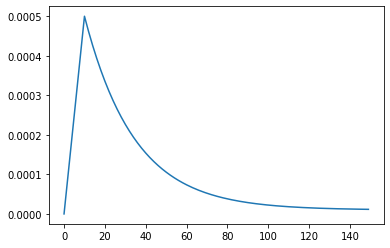

In [ ]:
# Learning rate
import matplotlib.pyplot as plt

start_lr = 1e-7
min_lr = 1e-5
max_lr = 5e-4
rampup_epochs = 10
sustain_epochs = 0
exp_decay = .96
d_model = 512

current_epoch = 0

def lrfn(epoch):
    global current_epoch

    if current_epoch < rampup_epochs:
        lr = (max_lr - start_lr)/rampup_epochs * current_epoch + start_lr
        current_epoch += 1
        return lr
    elif current_epoch < rampup_epochs + sustain_epochs:
        current_epoch += 1
        return max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay**(current_epoch-rampup_epochs-sustain_epochs) + min_lr
        current_epoch += 1
        return lr
    # steps_per_epoch = 500
    # step = epoch * steps_per_epoch
    # warmup_steps = rampup_epochs * steps_per_epoch
    # arg1 = step ** -0.5
    # arg2 = step * (warmup_steps ** -1.5)

    # return (d_model**-0.5) * min(arg1, arg2)

lr_callback = tensorflow.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rang = np.arange(150)
y = [lrfn(x) for x in rang]
print(y)
plt.plot(rang, y)
current_epoch = 93

In [ ]:
# Checkpoint
def set_cp(file = 'best.hdf5', monitor = 'val_loss', verbosity = 1, monitor_mode = 'auto', only_weights = True, best_only = True):
    global cp_callback

    cp_callback = keras.callbacks.ModelCheckpoint(filepath = save_path + 'best-{val_truncated_accuracy:.6f}.hdf5',
                                                monitor = monitor,
                                                verbose = verbosity,
                                                mode= monitor_mode, 
                                                save_weights_only = only_weights, 
                                                save_best_only = best_only)

set_cp(monitor = 'val_truncated_accuracy', only_weights=False)

## Train

In [ ]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', #https://github.com/LucaAngioloni/ProteinSecondaryStructure-CNN/blob/master/dataset.py
              sample_weight_mode='temporal',
              metrics=[truncated_accuracy, 'accuracy','mae'])


In [ ]:
trainX = np.load('/content/training-needs/trainX.npy')
print(trainX.shape)

(10029, 700, 57)


In [ ]:
trainY = np.load('/content/training-needs/trainY.npy')[:,:,:8]
print(trainY.shape)

(10029, 700, 8)


In [ ]:
trainAttm = np.load('/content/training-needs/trainAttM.npy')
print(trainAttm.shape)

(10029, 700)


In [ ]:
trainPosIds = np.array(range(700))
trainPosIds = np.repeat([trainPosIds], int(trainX.shape[0]), axis=0)
print(trainPosIds.shape)

(10029, 700)


In [ ]:
validationX = np.load('/content/training-needs/validationX.npy')
print(validationX.shape)
validationY = np.load('/content//training-needs/validationY.npy')[:,:,:8]
print(validationY.shape)
validationAttm = np.load('/content/training-needs/validationAttM.npy')
print(validationAttm.shape)
validationPosIds = np.array(range(700))
validationPosIds = np.repeat([validationPosIds], int(validationX.shape[0]), axis=0)
print(validationPosIds.shape)

(983, 700, 57)
(983, 700, 8)
(983, 700)
(983, 700)


In [ ]:
trainX = np.float32(trainX)
trainAttm = np.float32(trainAttm)
trainPosIds = np.float32(trainPosIds)
trainY = np.int32(trainY)
validationX = np.float32(validationX)
validationAttm = np.float32(validationAttm)
validationPosIds = np.float32(validationPosIds)
validationY = np.int32(validationY)

In [ ]:
print(keras.backend.floatx())

float32


In [ ]:
total_epochs = 150

In [ ]:
## run1
history = model.fit(
    x=[trainX,trainAttm,trainPosIds],
    y=trainY,
    batch_size=20,
    epochs=total_epochs,
    verbose=1,
    validation_data=([validationX,validationAttm,validationPosIds],validationY),
    # validation_batch_size = 8,
    shuffle=True,
    workers = -1,
    callbacks=[lr_callback, es_callback, cp_callback]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10029 samples, validate on 983 samples
Epoch 1/150

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-07.
10029/10029 [==============================] - 379s 38ms/step - loss: 12.5724 - truncated_accuracy: 0.1141 - accuracy: 0.1307 - mae: 0.1553 - val_loss: 12.4097 - val_truncated_accuracy: 0.1299 - val_accuracy: 0.1420 - val_mae: 0.1538

Epoch 00001: val_truncated_accuracy improved from -inf to 0.12992, saving model to /content/drive/MyDrive/bio-data/AN1-saint-base-build-MHA-2-CLB-FinalRun-2/best-0.129916.hdf5
Epoch 2/150

Epoch 00002: LearningRateScheduler reducing learning rate to 5.009000000000001e-05.
10029/10029 [==============================] - 320s 32ms/step - loss: 10.9555 - truncated_accuracy: 0.3674 - accuracy: 0.1536 - mae: 0.1417 - val_loss: 9.6536 - val_truncated_accuracy: 0.5394 - val_accuracy: 0.1854 - val_mae: 0.1296

Epoch 00002: val_truncated_accurac

In [ ]:
## run2
history = model.fit(
    x=[trainX,trainAttm,trainPosIds],
    y=trainY,
    batch_size=20,
    epochs=total_epochs,
    verbose=1,
    validation_data=([validationX,validationAttm,validationPosIds],validationY),
    # validation_batch_size = 8,
    shuffle=True,
    workers = -1,
    callbacks=[lr_callback, es_callback, cp_callback]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10029 samples, validate on 983 samples
Epoch 1/150

Epoch 00001: LearningRateScheduler reducing learning rate to 2.6546586816868657e-05.
10029/10029 [==============================] - 380s 38ms/step - loss: 0.2071 - truncated_accuracy: 0.7791 - accuracy: 0.5350 - mae: 0.1092 - val_loss: 0.2213 - val_truncated_accuracy: 0.7626 - val_accuracy: 0.5658 - val_mae: 0.1097

Epoch 00001: val_truncated_accuracy improved from -inf to 0.76262, saving model to /content/drive/MyDrive/bio-data/AN1-saint-base-build-MHA-2-CLB-FinalRun-2/best-0.762620.hdf5
Epoch 2/150

Epoch 00002: LearningRateScheduler reducing learning rate to 2.5884723344193908e-05.
10029/10029 [==============================] - 320s 32ms/step - loss: 0.2062 - truncated_accuracy: 0.7794 - accuracy: 0.5323 - mae: 0.1092 - val_loss: 0.2215 - val_truncated_accuracy: 0.7625 - val_accuracy: 0.5356 - val_mae: 0.1096

Epoch 00002: val_tr

**Inference**

In [ ]:
############## change validation set to other set for validations
############## 

file_ = 'test2018'
predX = np.load('/content/training-needs/'+file_+'X.npy')
print(predX.shape)
predY = np.load('/content/training-needs/'+file_+'Y.npy')[:,:,:8]
print(predY.shape)
predAttm = np.load('/content/training-needs/'+file_+'AttM.npy')
print(predAttm.shape)
predPosIds = np.array(range(700))
predPosIds = np.repeat([predPosIds], int(predX.shape[0]), axis=0)
print(predPosIds.shape)

(250, 700, 57)
(250, 700, 8)
(250, 700)
(250, 700)


In [ ]:
# predictions = model.predict([validationX,validationAttm,validationPosIds],verbose = 1)
model.evaluate([predX,predAttm,predPosIds], predY,verbose = 1)

250/250 [==============================] - 3s 11ms/step


[0.22568612217903136,
 0.7405083179473877,
 0.5707428455352783,
 0.11278259754180908]